<a href="https://colab.research.google.com/github/pathilink/criteo_case/blob/main/notebook/criteo_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=#FE5B00>Criteo</font> <font color=#13008E>Analytics Case</font>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format) # scientific notation

## Data

In [3]:
df = pd.read_excel('/content/drive/MyDrive/test/criteo/criteo_analytics_case_study_2025.xlsx')
df.sample(5)

,Year,Month,Country,Advertiser_ID,Industry,Clicks,Displays,Client_Sales,Client_Revenue
10442,2024,5,FR,A681,OTHER,3508,1785560,54,"11,916.10"
22710,2024,11,JP,A1408,TOYS & GADGETS,97005,19154813,1947,"81,748.77"
31454,2023,9,US,A2048,FASHION / LUXURY,16710,4124094,282,"65,927.10"
20911,2024,7,GB,A1290,OTHER,34093,9058065,3794,"47,316.70"
30702,2023,11,US,A1998,HOME IMPROVEMENT / GARDENING / INTERIOR DESIGN,2450,278101,24,"2,463.54"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32961 entries, 0 to 32960
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            32961 non-null  int64  
 1   Month           32961 non-null  int64  
 2   Country         32961 non-null  object 
 3   Advertiser_ID   32961 non-null  object 
 4   Industry        32961 non-null  object 
 5   Clicks          32961 non-null  object 
 6   Displays        32961 non-null  object 
 7   Client_Sales    32961 non-null  int64  
 8   Client_Revenue  32961 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.3+ MB


In [5]:
df.groupby('Country')['Country'].count().rename('Total')

,Total
Country,
BR,2859
DE,5555
FR,8546
GB,5515
JP,929
US,9557


In [6]:
df.groupby('Year')['Year'].count().rename('Total')

,Total
Year,
2023,14335
2024,18626


In [7]:
df_ = df.copy()

In [8]:
# treat nulls

# '[NULL]' -> NaN
df_['Clicks'] = pd.to_numeric(df_['Clicks'], errors='coerce')
df_['Displays'] = pd.to_numeric(df_['Displays'], errors='coerce')

df_[['Clicks', 'Displays']] = df_[['Clicks', 'Displays']].fillna(0).astype(int)
df_[['Clicks', 'Displays']].sample(3)

,Clicks,Displays
27648,116895,69188296
31381,0,0
4701,66,9362


## Question 1
We are trying to assess how much the Brazil (BR) market is exposed to its top clients. How many clients are needed to make up 40% of Brazil’s clicks in 2024?

In [9]:
df_br = df_.query('Country == "BR" & Year == 2024')
df_br.head()

,Year,Month,Country,Advertiser_ID,Industry,Clicks,Displays,Client_Sales,Client_Revenue
1,2024,5,BR,A2,AUTOMOBILE / MOTO / BOATING,57114,4709714,722,"5,746,100.93"
2,2024,6,BR,A2,AUTOMOBILE / MOTO / BOATING,22903,1479509,579,"4,847,614.12"
3,2024,7,BR,A2,AUTOMOBILE / MOTO / BOATING,50219,3394187,742,"6,634,991.64"
4,2024,8,BR,A2,AUTOMOBILE / MOTO / BOATING,50586,3621244,477,"4,041,559.78"
5,2024,9,BR,A2,AUTOMOBILE / MOTO / BOATING,50009,3600405,433,"3,296,489.65"


In [10]:
clicks_by_advertiser = df_br.groupby('Advertiser_ID')['Clicks'].sum().sort_values(ascending=False)#.reset_index()
clicks_by_advertiser.head(10)

,Clicks
Advertiser_ID,
A9,7720264
A24,5198795
A13,4227974
A33,2800175
A5,2168307
A22,2101798
A99,993325
A75,939631
A139,875097


In [11]:
total_clicks = clicks_by_advertiser.sum()
print(f'Total clicks: {total_clicks}')

# cumulative sum
clicks_cumsum = clicks_by_advertiser.cumsum()
clicks_cumsum.head(10)

Total clicks: 55851836


,Clicks
Advertiser_ID,
A9,7720264
A24,12919059
A13,17147033
A33,19947208
A5,22115515
A22,24217313
A99,25210638
A75,26150269
A139,27025366


In [12]:
# 40% clicks > 22115515
total_clicks * 0.4

np.float64(22340734.400000002)

In [13]:
(clicks_cumsum < total_clicks * 0.4).head(10)

,Clicks
Advertiser_ID,
A9,True
A24,True
A13,True
A33,True
A5,True
A22,False
A99,False
A75,False
A139,False


In [14]:
num_clients = (clicks_cumsum < total_clicks * 0.4).sum() + 1
print(f'Number of clients needed: {num_clients}')

Number of clients needed: 6


**clicks_cumsum**: This is a series with the cumulative sum of clicks per customer, ordered from the highest to the lowest number of clicks.

__total_clicks * 0.4__: This represents 40% of the total number of clicks.

__clicks_cumsum < total_clicks * 0.4__: This comparison returns a Boolean series (True or False) indicating whether the cumulative sum up to that point is still below 40% of the clicks.

__.sum()__ on a Boolean series: Sums True values as 1 and False values as 0. So, this gives you how many customers have contributed until you get close, but still below 40%.

__+ 1__: Adds one more customer, which is the one needed to finally exceed or reach 40%. After all, sum() stopped at the last one that was still below.

In [15]:
clicks_pct = (clicks_cumsum / clicks_by_advertiser.sum() * 100).rename('Cumulative clicks %')
clicks_pct.head(10)

,Cumulative clicks %
Advertiser_ID,
A9,13.82
A24,23.13
A13,30.70
A33,35.71
A5,39.60
A22,43.36
A99,45.14
A75,46.82
A139,48.39


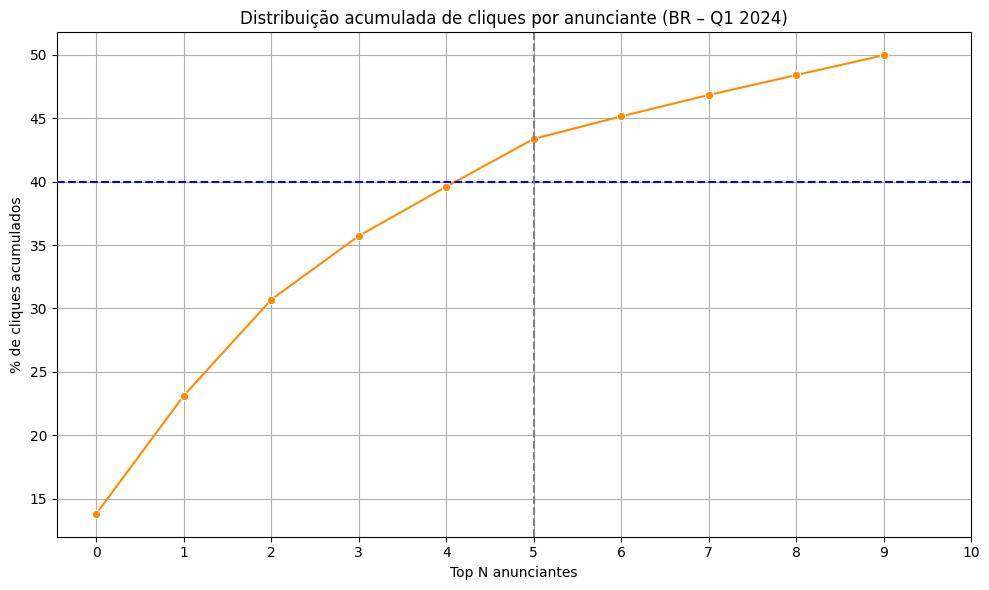

In [16]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=clicks_pct.head(10).values, marker="o", color="darkorange")

# Destaque o ponto dos 40%
plt.axhline(y=40, color='blue', linestyle='--')
plt.axvline(x=5, color='gray', linestyle='--')  # índice 5 = 6º cliente (zero-based)

plt.title("Distribuição acumulada de cliques por anunciante (BR – Q1 2024)")
plt.xlabel("Top N anunciantes")
plt.ylabel("% de cliques acumulados")
plt.xticks(range(0, 11))  # até top 10
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 2
What is the impact of the holiday sales period on the fashion industry? How does user behavior change during this time? (Pick a country of your choice)

In [17]:
df_fr_fashion = df_.query('Industry.str.startswith("FASHION") & Country == "FR"', engine='python')
df_fr_fashion.head()

,Year,Month,Country,Advertiser_ID,Industry,Clicks,Displays,Client_Sales,Client_Revenue
8599,2023,1,FR,A567,FASHION / LUXURY,333655,121967462,6431,"516,107.81"
8600,2023,2,FR,A567,FASHION / LUXURY,227825,85133506,4459,"352,355.80"
8601,2023,3,FR,A567,FASHION / LUXURY,164093,67557399,2912,"243,903.06"
8602,2023,4,FR,A567,FASHION / LUXURY,191699,67134949,3993,"286,151.87"
8603,2023,5,FR,A567,FASHION / LUXURY,193435,63078482,4145,"311,872.44"


<font color=#13008E>The end-of-year sales period is November and December (months 11 and 12).
<br>
I should compare this period with the rest of the year (months 1 to 10) - focus on clicks, displays, sales or revenue.
</font>

In [18]:
df_fr_fashion.groupby('Month')['Month'].count().rename('Total')

,Total
Month,
1,169
2,171
3,166
4,167
5,166
6,174
7,175
8,178
9,166


In [19]:
# separating periods
before_holidays = df_fr_fashion[df_fr_fashion['Month'] <= 10]
holiday_season = df_fr_fashion[df_fr_fashion['Month'] >= 11]

# comparing averages by month
before_avg = before_holidays[['Clicks', 'Displays', 'Client_Sales', 'Client_Revenue']].mean()
holiday_avg = holiday_season[['Clicks', 'Displays', 'Client_Sales', 'Client_Revenue']].mean()

In [20]:
before_avg

,0
Clicks,"15,465.19"
Displays,"3,787,375.21"
Client_Sales,320.72
Client_Revenue,"25,476.96"


In [21]:
holiday_avg

,0
Clicks,"17,355.28"
Displays,"3,552,459.70"
Client_Sales,366.55
Client_Revenue,"46,567.11"


In [22]:
# percentage difference
impact = ((holiday_avg - before_avg) / before_avg) * 100

print("Percentage change over the year-end period (Nov-Dec):")
df_impact = impact.round(2).rename('Percentage').to_frame().reset_index()
df_impact

Percentage change over the year-end period (Nov-Dec):


,index,Percentage
0,Clicks,12.22
1,Displays,-6.20
2,Client_Sales,14.29
3,Client_Revenue,82.78


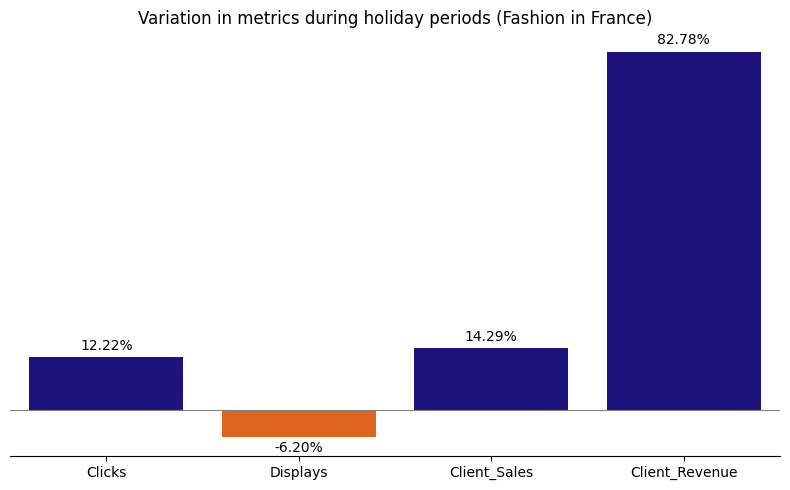

In [23]:
# Nov–Dec vs avg year

colors = ['#13008E' if x >= 0 else '#FE5B00' for x in df_impact['Percentage']]

plt.figure(figsize=(8, 5))
ax=sns.barplot(data=df_impact, x='index', y='Percentage', hue='index', legend=False, palette=colors)

# labels
for i, v in enumerate(df_impact['Percentage']):
    plt.text(i, v + (1 if v > 0 else -1), f'{v:.2f}%', ha='center', va='bottom' if v > 0 else 'top')

# remove subtitles and Y-axis
ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params(axis='y', left=False, labelleft=False)  # removes ticks and labels from the Y axis
sns.despine(left=True)  # remove the left edge

plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Variation in metrics during holiday periods (Fashion in France)')
plt.tight_layout()
plt.show()

## Question 3
How much client revenue will we generate for our US advertisers in Q1 2025? Present your methodology.

In [24]:
df_us_2023 = df_.query('Country == "US" & Year == 2023 & Month in [1, 2, 3]')
revenue_q1_2023 = df_us_2023['Client_Revenue'].sum()
print(f'Revenue Q1 2023 (US): ${revenue_q1_2023:,.2f}')

df_us_2024 = df_.query('Country == "US" & Year == 2024 & Month in [1, 2, 3]')
revenue_q1_2024 = df_us_2024['Client_Revenue'].sum()
print(f'Revenue Q1 2024 (US): ${revenue_q1_2024:,.2f}')

Revenue Q1 2023 (US): $81,929,089.52
Revenue Q1 2024 (US): $298,461,921.57


In [25]:
growth_rate = (revenue_q1_2024 - revenue_q1_2023) / revenue_q1_2023
print(f'Growth rate: {growth_rate * 100:.2f}%')

estimated_revenue_q1_2025 = revenue_q1_2024 * (1 + growth_rate)
print(f"Estimated revenue Q1 2025 (US): ${estimated_revenue_q1_2025:,.2f}")

Growth rate: 264.29%
Estimated revenue Q1 2025 (US): $1,087,275,827.81


<font color=#13008E>
<strong>Estimated US Advertiser Revenue in Q1 2025:</strong>
<br>
- I used historical data from the first quarters of 2023 and 2024 to project performance in 2025.
<br>
- The growth rate observed between 2023 and 2024 was 264%.
<br>
- Applying this rate to the 2024 figure, we estimate that customer revenue in the US in Q1 2025 will be approximately US$ 1,087,275,827.81.
<br>
- This approach assumes that the annual growth pattern will be maintained, given recent history.

</font>

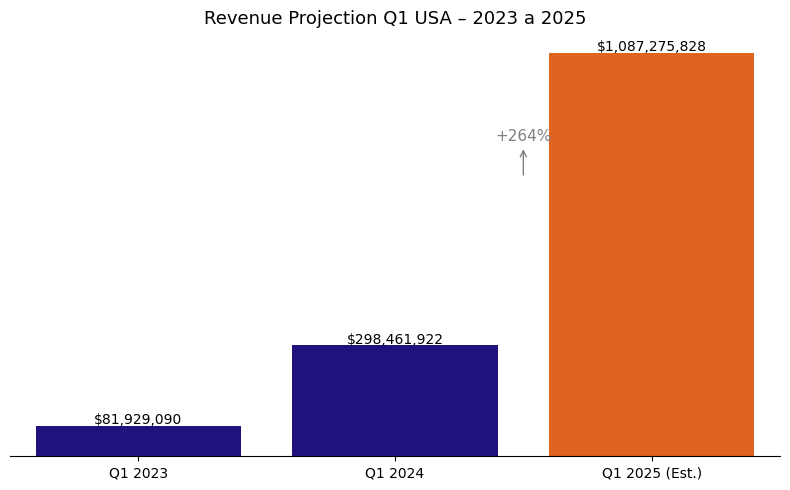

In [26]:
# data
quarters = ['Q1 2023', 'Q1 2024', 'Q1 2025 (Est.)']
revenues = [revenue_q1_2023, revenue_q1_2024, estimated_revenue_q1_2025]
colors_ = ["#13008E", "#13008E", "#FE5B00"]  # azul, azul, laranja

plt.figure(figsize=(8, 5))
bars = sns.barplot(x=quarters, y=revenues, hue=quarters, legend=False, palette=colors_)

# labels on the bars
for i, valor in enumerate(revenues):
    plt.text(i, valor + 5e6, f"${valor:,.0f}", ha='center', fontsize=10)

# annotation of growth
plt.annotate(
    "+264%",
    xy=(1.5, 750000000),
    xytext=(1.5, 850000000),
    arrowprops=dict(arrowstyle="<-", color='gray'),
    ha='center', fontsize=11, color='gray'
)

# style
plt.title("Revenue Projection Q1 USA – 2023 a 2025", fontsize=13)
plt.ylabel("")
plt.xlabel("")
bars.tick_params(axis='y', left=False, labelleft=False)  # removes ticks and labels from the Y axis
sns.despine(left=True)  # remove the left edge
plt.tight_layout()
plt.show()


## Question 4
What would your advice to the Criteo leadership be for 2025?

<font color=#13008E>
<strong>Based on the data analyzed, I recommend Criteo leadership to focus on:</strong>
<br>
- Client Concentration Management in Key Markets:
In Brazil, only 6 clients are responsible for 40% of clicks in 2024. This high concentration indicates potential risk and dependency. I advise diversifying the client base.
<br>
- Maximize Holiday Sales Impact for Fashion Clients:
During the Nov–Dec holiday season, user behavior shifts significantly, with a 12.22% increase in clicks and 82.78% growth in client revenue for the fashion sector. This highlights a major seasonal opportunity.
<br>
- Capitalize on US Market Momentum:
With an expected 264.29% growth in US client revenue for Q1 2025, the momentum is strong.
</font>